Pasos:

Extraer con cpptraj las trayectorias con únicamente los CA y proteina

% Ya en eel nootebook de pcas

PAra cada ensayo:

- Carga la conformación inicial
- Carga las trayectorias (5 de 20 ns)
- para PCA
    - Alinear con respecto a la inicial (la estructura cristalográfica inicial)
         - la idea es que la incial es un aestructura cristalográfica y está proyección original
    - Alinear todas las conformaciones de la producción, de tal manera que el clustering y el PCA permita extraer las conformaciones centroides de únicamente este espacio
    - Usar los residuos definidos por Pisani
    - Usar los residuos de la estructura secundaria
    - Usar los residuos del pocket
- Proyección con MDS
    - Las estruturas se alinean con respecto al frame 1 de las cristalográficas
    - Revisar el notebook proyeccion, dejamos pendiente por ahora esta parte
 

In [7]:
import pandas as pd
import numpy as np
import pytraj as pyt
import glob, os, sys
# Añadimos la ruta del directorio raíz para tener acceso a los archivos y módulos
sys.path.append(r'..')

Residuos de referencia para generar los resultados.

In [6]:
from modules.subsecuencias_cdk2 import *
pisiani_residues = get_pisani_residues(sep=",")
pocket_residues = get_pocket_residues(sep=",")

In [3]:
DM_DIR =  os.path.join('../..', 'ARCHIVOS', 'DINAMICA')

In [12]:
# Primer conformación inicial
ref_conf_4fku_path = F'{DM_DIR}/4fku/sa_dm/rep_1/cdk2'
ref_conf_4fku = pyt.load(filename = F'{ref_conf_4fku_path}.inpcrd',
                         top = F'{ref_conf_4fku_path}.prmtop',
                        # Seleccionamos únicamente la proteína
                         mask = F'!(:WAT:Cl-:Na+:ETA)')

In [11]:
# Estructura de referencia
import nglview as nv
nv.show_pytraj(ref_conf_4fku)

NGLWidget()

In [104]:
import matplotlib.pyplot as plt
from modules.plotting_functions import plot_points, plot_anotation_labels
import seaborn as sns
import pylab
sns.set(context = 'talk', style = 'ticks')

In [102]:
# Primer sitema a evaluar
path_4fku_mxs_plain = os.path.join(DM_DIR, '4fku', 'mix_solv')
# Cargamos todas las trayectorias
prmtop_files = sorted(glob.glob(os.path.join(path_4fku_mxs_plain, 'rep_*', '4_prod', 'PROT*prmtop')))
nc_files = sorted(glob.glob(os.path.join(path_4fku_mxs_plain, 'rep_*', '4_prod', 'PROT*_prod.nc')))

# Lista de trayectorias
traj_list = [pyt.iterload(i, prmtop_files[0]) for i in nc_files]
# Diccionario de trayectorias
mask = F"(:{pisiani_residues})&(@CA)"
dic_trajs = {F'rep_{i}': traj_list[i].superpose(ref = ref_conf_4fku, 
                                                mask = mask)
             for i in range (len(traj_list))}
# Cálculo del Rmsd
dic_rmsd = {key: pyt.rmsd(traj, ref = ref_conf_4fku,  mask = mask) 
                for key, traj in dic_trajs.items()}
# Se obtienen los PCA independientes
dic_pca_traj = {key: pyt.pca(traj, mask = mask, n_vecs = 2) 
                for key, traj in dic_trajs.items()}

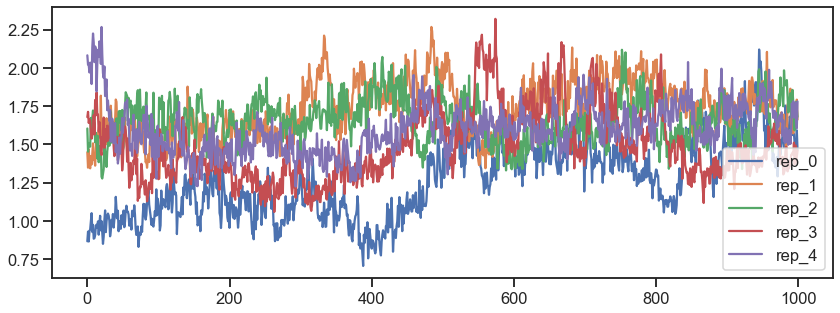

In [109]:
# Gráfica de los RMSD
fig = plt.figure(figsize=(14, 5))
for key, rmsd in dic_rmsd.items():
    sns.lineplot(x = range(len(rmsd)), y = rmsd, label = key)

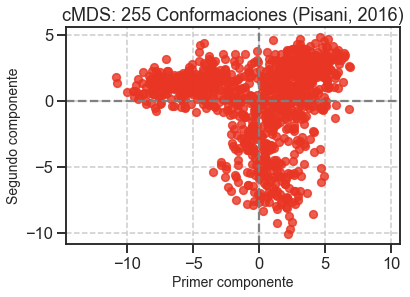

In [110]:
# Plots de PCA
plot_points(mds = dic_pca_traj['rep_1'][0], alpha=0.8,
            title = "cMDS: 255 Conformaciones (Pisani, 2016)")

In [93]:
# Creamos una tryectoria unica
full_traj = ref_conf_4fku.copy()
for traj in traj_list:
    full_traj.append_xyz(traj.xyz)

full_traj

pytraj.Trajectory, 5001 frames: 
Size: 0.541915 (GB)
<Topology: 4848 atoms, 298 residues, 1 mols, PBC with box type = ortho>
           

In [94]:
full_traj.superpose(ref = ref_conf_4fku, mask = F"(:{pisiani_residues})&(@CA)")

pytraj.Trajectory, 5001 frames: 
Size: 0.541915 (GB)
<Topology: 4848 atoms, 298 residues, 1 mols, PBC with box type = ortho>
           

In [99]:
# pca
pca = pyt.pca(full_traj, mask = F"(:{pisiani_residues})&(@CA)", n_vecs = 2) 

In [161]:
pca[0][1, 0]

3.4183853

(-19.2392757206234, 25.14126191037873, -14.497458990699151, 13.199858627146813)

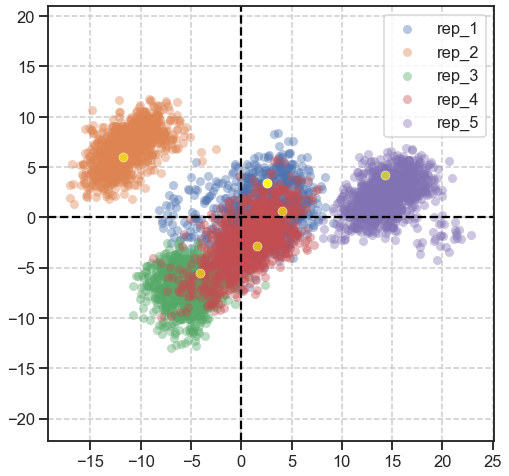

In [252]:
# Proyección única
fig, ax = plt.subplots(figsize=(8, 8))
colores = ['Purples', 'Reds', 'Greens', 'Blues', 'Greys']
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
for i in range(5):
    ax = sns.scatterplot(x = pca[0][0, (i*1000)+1: ((i+1)*1000)+1], 
                    y = pca[0][1, (i*1000)+1: ((i+1)*1000)+1],
                    alpha=0.4, label = F'rep_{i+1}', linewidth=0)
ax = sns.scatterplot(x = pca[0][0, 0:1], y = pca[0][1, 0:1], color = 'yellow')
ax = sns.scatterplot(x = pca[0][0, cluster_data.centroids], 
                     y = pca[0][1, cluster_data.centroids], color = 'yellow', alpha = 0.6)
plt.axhline(0, color='black',  linestyle='--')
plt.axvline(0, color='black',  linestyle='--')
plt.grid(linestyle='--')
plt.axis('equal')


In [226]:
# Clustering
import scipy
import scipy.cluster.hierarchy

# Cálculo de la amtriz de rmsd
distances = pyt.pairwise_rmsd(full_traj, mask = F"(:{pisiani_residues})&(@CA)")

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


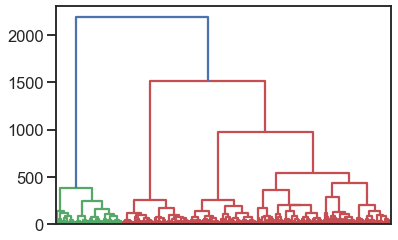

In [227]:
linkage = scipy.cluster.hierarchy.ward(distances)

scipy.cluster.hierarchy.dendrogram(linkage, no_labels=True, count_sort='descendent')
None

In [254]:
# Clustering con sklearn
from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(n_clusters=6, linkage='ward').fit(distances)

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [259]:
sum(ward.labels_ == 2)
ward.

1000

In [249]:
# Clusterign con kmeans
cluster_data = pyt.cluster.kmeans(full_traj, mask = F"(:{pisiani_residues})&(@CA)", 
                                  n_clusters = 5)

In [250]:
cluster_data.cluster_index == 1

array([ True,  True,  True, ..., False, False, False])

In [251]:
cluster_data.centroids

array([2664,  272, 1593, 4551, 3406], dtype=int32)